# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 350

---

## Import data

This code is provided for you. Some columns with network and score-related data are dropped.

The remaining columns will be `#AUTHID`, `STATUS`, `cEXT`, `cNEU`, `cAGR`, `cCON`, `cOPN`, and `DATE`:

| Variable name | Description                                                                      |
|---------------|----------------------------------------------------------------------------------|
| `#AUTHID`     | Author ID code, unique per user                                                  |
| `STATUS`      | Text of a Facebook status                                                        |
| `cEXT`        | Author extroversion category, `y` for above median and `n` for below median      |
| `cNEU`        | Author neuroticism category, `y` for above median and `n` for below median       |
| `cAGR`        | Author agreeableness category, `y` for above median and `n` for below median     |
| `cCON`        | Author conscientiousness category, `y` for above median and `n` for below median |
| `cOPN`        | Author openness category, `y` for above median and `n` for below median          |
| `DATE`        | Time stamp of original Facebook status                                           |


In [2]:
df = pd.read_csv('data/mypersonality.csv')
# df = pd.read_csv('data/mypersonality_noprofanity.csv') # comment out above & uncomment this to use mypersonality_noprofanity.csv

dropcols = [
    # these are network-related columns:
    'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 'DENSITY',
    'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY',
    # these are score-related columns;
    # we will use the catgories instead:
    'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN'
]

df.drop(columns=dropcols, inplace=True)
df.head(3)

#AUTHID  \
0  b7b7764cfa1c523e4e93ab2a79a946c4   
1  b7b7764cfa1c523e4e93ab2a79a946c4   
2  b7b7764cfa1c523e4e93ab2a79a946c4   

                                                                                                                      STATUS  \
0                                                                                                likes the sound of thunder.   
1                                                            is so sleepy it's not even funny that's she can't get to sleep.   
2  is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3   

  cEXT cNEU cAGR cCON cOPN               DATE  
0    n    y    n    n    y  06/19/09 03:21 PM  
1    n    y    n    n    y  07/02/09 08:41 AM  
2    n    y    n    n    y  06/15/09 01:15 PM

## Data cleaning

It's often more convenient to work with integers than strings. Convert the personality columns to 0 and 1, with 0 meaning 'below the median' and 1 meaning 'above the median.'

In [3]:
def map_func(value):
    if value == 'y':
        return 1
    else:
        return 0
    
for column in ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']:
    df[column] = df[column].map(map_func)

In [4]:
df.head(3)

#AUTHID  \
0  b7b7764cfa1c523e4e93ab2a79a946c4   
1  b7b7764cfa1c523e4e93ab2a79a946c4   
2  b7b7764cfa1c523e4e93ab2a79a946c4   

                                                                                                                      STATUS  \
0                                                                                                likes the sound of thunder.   
1                                                            is so sleepy it's not even funny that's she can't get to sleep.   
2  is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3   

   cEXT  cNEU  cAGR  cCON  cOPN               DATE  
0     0     1     0     0     1  06/19/09 03:21 PM  
1     0     1     0     0     1  07/02/09 08:41 AM  
2     0     1     0     0     1  06/15/09 01:15 PM

-----

## A first look at the dataset

In this section, check:

- How many observations are there in the dataset?
    * 9916
- How many unique `#AUTHID` codes are there?
    * 250
- How many `y` and `n` values are in each of the personality category columns?
    * cEXT: 5707 N, 4209 Y
    * cNEU: 6199 N, 3717 Y
    * cAGR: 5267 N, 4649 Y
    * cCON: 5360 N, 4556 Y
    * cOPN: 7369 N, 2547 Y

In [5]:
df.shape

(9916, 8)

In [6]:
df['#AUTHID'].nunique()

250

In [7]:
for i in ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']:
    print(df[i].value_counts())

0    5707
1    4209
Name: cEXT, dtype: int64
0    6199
1    3717
Name: cNEU, dtype: int64
1    5267
0    4649
Name: cAGR, dtype: int64
0    5360
1    4556
Name: cCON, dtype: int64
1    7369
0    2547
Name: cOPN, dtype: int64



---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status. Some personality types might be more long-winded than others!

### Create a new column called `status_char_length` that contains the character length of each status

> Note: You can do this in one line with `map`.

In [8]:
df['status_char_length'] = df['STATUS'].map(lambda x: len(x))

In [9]:
df.head(3)

#AUTHID  \
0  b7b7764cfa1c523e4e93ab2a79a946c4   
1  b7b7764cfa1c523e4e93ab2a79a946c4   
2  b7b7764cfa1c523e4e93ab2a79a946c4   

                                                                                                                      STATUS  \
0                                                                                                likes the sound of thunder.   
1                                                            is so sleepy it's not even funny that's she can't get to sleep.   
2  is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3   

   cEXT  cNEU  cAGR  cCON  cOPN               DATE  status_char_length  
0     0     1     0     0     1  06/19/09 03:21 PM                  27  
1     0     1     0     0     1  07/02/09 08:41 AM                  63  
2     0     1     0     0     1  06/15/09 01:15 PM                 121

### Create a new column called `status_word_count` that contains the number of words in each status

> Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [10]:
df['status_word_count'] =  df['STATUS'].map(lambda x: len(x.split(' ')) )

In [11]:
df.head(3)

#AUTHID  \
0  b7b7764cfa1c523e4e93ab2a79a946c4   
1  b7b7764cfa1c523e4e93ab2a79a946c4   
2  b7b7764cfa1c523e4e93ab2a79a946c4   

                                                                                                                      STATUS  \
0                                                                                                likes the sound of thunder.   
1                                                            is so sleepy it's not even funny that's she can't get to sleep.   
2  is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3   

   cEXT  cNEU  cAGR  cCON  cOPN               DATE  status_char_length  \
0     0     1     0     0     1  06/19/09 03:21 PM                  27   
1     0     1     0     0     1  07/02/09 08:41 AM                  63   
2     0     1     0     0     1  06/15/09 01:15 PM                 121   

   status_word_count  
0                  5  
1                 13  
2                 26

---

## Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

### Show the five longest and five shortest statuses based off of `status_word_count`

In [12]:
# shortest
df.sort_values('status_word_count').head(5)

#AUTHID  \
8316  c5d9ffcb242053b0abdebe0d684fea3a   
7614  2382eeba332f59ff29cf63a839a33f9a   
9099  715c9eb832dc833a0b6409ddccd268b1   
229   ecbddbfe00e0f83cfdb802a7186061c7   
4014  e4a512374eee079d2b8acc2ce69990d5   

                                                                          STATUS  \
8316                                                               *PROPNAME*'s?   
7614  http:////ca.news.yahoo.com//s//capress//091008//world//eu_nobel_literature   
9099                                                                          no   
229                                                                      MLIG!!!   
4014                                                                        2010   

      cEXT  cNEU  cAGR  cCON  cOPN               DATE  status_char_length  \
8316     0     0     0     1     0  10/17/09 10:57 PM                  13   
7614     0     1     0     0     0  10/08/09 08:30 PM                  74   
9099     0     0     0     1     1  09/13/09 03:33 AM                   2   
229      1     0     1     0     1  09/21/09 02:53 AM                   7   
4014     1     0     1     0     1  01/01/09 07:00 PM                   4   

      status_word_count  
8316                  1  
7614                  1  
9099                  1  
229                   1  
4014                  1

In [13]:
# longest
df.sort_values('status_word_count').tail(5)

#AUTHID  \
6989  502db2fcfe26705ae16a46c5cb2ad2e5   
2399  b2be41464b53ffc6deae9536ddfd3aee   
5680  1ece40ac9b657dea8c22a1fe58d3a6fe   
496   9a8cf1dcb2de1a8f70c4745a636bbb96   
2188  692758eda219c4fdb6aa64e929be3ff0   

                                                                                                                                                                                                                                                                                                                                                             STATUS  \
6989  If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost ...   
2399                                                                                                 And you run and you run to catch up with the sun but it's sinking.               Racing around to come up behind you again.               The sun is the same in a relative way but you're older.               Shorter of breath and one day closer to death.   
5680  I always make it a rule to let the other fellow fire first.  If a man wants to fight, I argue the question with him and try to show him how foolish it would be.  If he can't be dissuaded, why then the fun begins but I always let him have first crack.  Then when I fire, you see, I have the verdict of self-defence on my side.  I know that he is p...   
496   Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it.  Dmv:  Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can...   
2188                                                                                                just found an organization called Think Before You Speak that flips out about people saying, "that's gay," claiming that it's offensive.  That's pretty gay, if you ask me.                                                                                       

      cEXT  cNEU  cAGR  cCON  cOPN               DATE  status_char_length  \
6989     0     1     1     0     1  02/18/11 08:33 AM                 384   
2399     1     0     1     0     1  09/17/09 02:49 AM                 254   
5680     0     0     1     0     1  12/07/09 04:07 AM                 395   
496      1     1     1     1     1  10/30/09 02:05 PM                 413   
2188     0     1     1     0     1  07/11/09 04:55 AM                 255   

      status_word_count  
6989                 85  
2399                 86  
5680                 88  
496                  91  
2188                113

---

## Investigating distribution of post lengths

We've now seen some of the shortest and longest posts in the dataset. But how common are short posts, and how common are long posts? 

Use visuals to show the distributions of post lengths.

> Note: There are multiple different types of visualizations you could use for this, and you could investigate this by looking at `status_word_count`, `status_char_length`, or both.

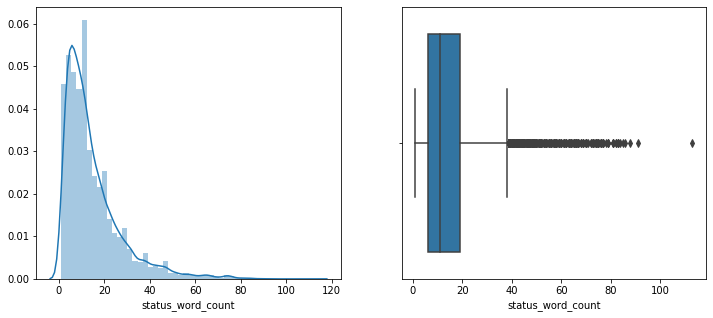

In [14]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
sns.distplot(df['status_word_count'],ax= axes[0]);
sns.boxplot(df['status_word_count'],ax= axes[1]);

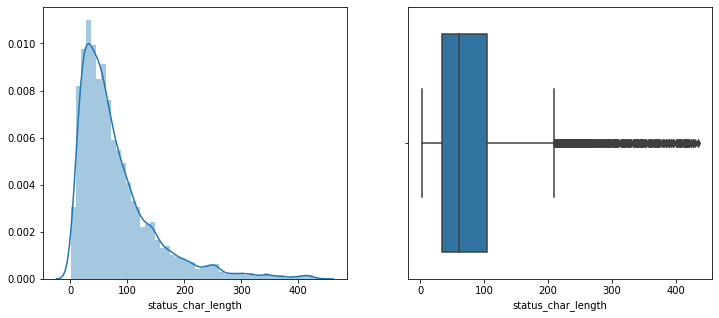

In [15]:
fig,axes = plt.subplots(1,2,figsize=(12,5))
sns.distplot(df['status_char_length'],ax= axes[0]);
sns.boxplot(df['status_char_length'],ax= axes[1]);

---

## Exploring personality categories and individual users

Because we have many posts per user for most users, doing EDA on the personality columns might be misleading. If we have 2,000 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `1` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there? Do we have the same number of posts per user, or do we have some more posts by some users than others?

In [16]:
# 250 different users
df['#AUTHID'].nunique()

250

In [17]:
df.groupby('#AUTHID')['STATUS'].count()

#AUTHID
00419a4c96b32cd63b2c7196da761274     1
02c37028a782cfda660c7243e45244bb     6
03133a828cd0cf52e3752813ce5d818f     5
03e6c4eca4269c183fa0e1780f73faba     8
06b055f8e2bca96496514891057913c3    12
                                    ..
f83aa7290cf3ae8ed75d6aee5ebbb559     6
fbe5aa478508d1dc931427ade5d9e1b4     3
fc1c9fb6c64740edcbbf8cfe9dde8b02    30
fe22087986fdcc65939c793fe0ec90a9    19
fffafe151f07a30a0ede2038a897b680    21
Name: STATUS, Length: 250, dtype: int64

### We have more posts for some users than others.

---

### Create a new dataframe called `unique_users` that only contains the `#AUTHID` and personality category columns

If you do this correctly, it should have 250 rows and 6 columns.*

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

> Note: *If using the `noprofanity` dataset, this number may be different.

In [18]:
unique_users = df.drop(['STATUS','status_char_length','status_word_count','DATE'],axis=1).drop_duplicates()

In [19]:
unique_users

#AUTHID  cEXT  cNEU  cAGR  cCON  cOPN
0     b7b7764cfa1c523e4e93ab2a79a946c4     0     1     0     0     1
102   318bf822d4f2bd3920367560218619c0     1     1     0     1     0
171   ecbddbfe00e0f83cfdb802a7186061c7     1     0     1     0     1
236   db39f7b2aad360b1033ec1f8fcd57f9c     1     1     0     1     1
246   4d035bd3fd8d9595d15cea9e388964be     1     1     0     0     1
...                                ...   ...   ...   ...   ...   ...
9909  a764ca41dca158d7a191505dcc8ce47f     1     0     1     1     0
9910  deb899e426c1a5c66c24eeb0d7df6257     0     0     1     0     1
9912  ea28a927cb6663480ea33ca917c3c8ba     1     1     1     1     1
9914  5532642937eb3497a43e15dbb23a9d2d     0     1     0     0     1
9915  a286b7286b1247d4a7851709e9f31e1e     1     1     0     1     1

[250 rows x 6 columns]

### Using `unique_users`, investigate personality

For this section, perform EDA on just the unique users. Create 2-3 tables or visuals to investigate.

Here are some prompts to get you started:

- What proportion of above-median openness users also exhibit above-median extroversion vs. below-median extroversion? What about other pairs of personality traits?
- Do any two personality traits appear to be correlated?
- Are about equal numbers of users above median conscientiousness and below median conscientiousness, or is there an imbalanced split? What about the other personality traits?
- Are any users below-median across all five personality traits? How many?
- Are any users above-median all five personality traits? How many?

For each dataframe or plot you end up with, remember to provide interpretation in markdown as well.

In [205]:
unique_users[unique_users['cOPN'] == 1]['cEXT'].value_counts(normalize=True)

0    0.590909
1    0.409091
Name: cEXT, dtype: float64

#### About 43.78% of users who show above-median openness also exhibit above-median extroversion.
#### And 56.22% of users who show above-median openness also exhibit below-median extroversion.

---

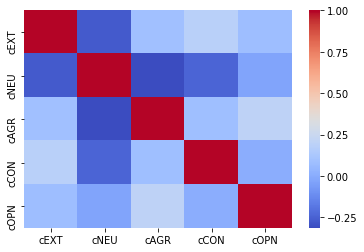

In [21]:
sns.heatmap(unique_users.corr(),cmap='coolwarm');

In [22]:
unique_users.corr()

cEXT      cNEU      cAGR      cCON      cOPN
cEXT  1.000000 -0.269335  0.091429  0.182399  0.079561
cNEU -0.269335  1.000000 -0.312656 -0.237050 -0.030387
cAGR  0.091429 -0.312656  1.000000  0.085410  0.204943
cCON  0.182399 -0.237050  0.085410  1.000000  0.008419
cOPN  0.079561 -0.030387  0.204943  0.008419  1.000000

#### Looks like cEXT and cNEU are slightly negetively correlated. cNEU and cAGR are  slightly negetively correlated as well.

---

In [23]:
for column in unique_users.drop('#AUTHID',axis=1).columns:
    print(unique_users[column].value_counts())

0    154
1     96
Name: cEXT, dtype: int64
0    151
1     99
Name: cNEU, dtype: int64
1    134
0    116
Name: cAGR, dtype: int64
1    130
0    120
Name: cCON, dtype: int64
1    176
0     74
Name: cOPN, dtype: int64


#### Most of the personality traits are imbalanced except cAGR and cCON.

----

In [204]:
unique_users.drop('#AUTHID',axis=1).sum(axis=1).value_counts()

3    83
2    77
4    43
1    40
5     4
0     3
dtype: int64

#### 3 users below-median all five personality traits
#### 5 users above-median all five personality traits

## Plots vs. Tables

(Short answer.) Explain when you might present a visualization versus when you might present a table of summary statistics. You can provide your answer using sentences or bullet points.

* Using plots when I want to reveal relationships among whole sets of values.
* Using tables when I want to reveal the precise values.

---

## Exploring status length and word count based on personality

### Using `groupby()`, find the mean status length and status word count for posts by users in the above-median and below-median categories of each of the personality traits

> Note: Using `groupby()` five separate times is the easiest way to do this.

In [25]:
for column in ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']:
    print(df.groupby(column)[['status_char_length','status_word_count']].mean())

      status_char_length  status_word_count
cEXT                                       
0              79.866655          14.659891
1              81.704918          14.843906
      status_char_length  status_word_count
cNEU                                       
0              80.852396          14.753025
1              80.304278          14.712941
      status_char_length  status_word_count
cAGR                                       
0              80.976769          14.857389
1              80.355800          14.632618
      status_char_length  status_word_count
cCON                                       
0              81.920149          14.969963
1              79.149034          14.465101
      status_char_length  status_word_count
cOPN                                       
0              85.686298          15.653318
1              78.905143          14.421631


     *It looks like for each personality trait, the differences of status length and word count between above median and below median are pretty small.
     *However, the difference in cOPN is the largest among all of the personality traits.

### Distribution of post length for above- and below-median personality traits

Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Visualize the distribution of status word counts of posts for users who are both above-median and below-median on that trait.

> Note: This can be done several ways -- using seaborn or matplotlib, and as overlapping histograms or as side-by-side or stacked histograms.

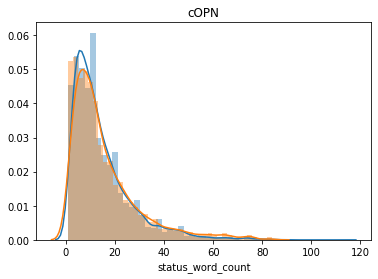

In [26]:
plt.title('cOPN')
sns.distplot(df[df['cOPN'] == 1]['status_word_count']);
sns.distplot(df[df['cOPN'] == 0]['status_word_count']);

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [28]:
cvec = CountVectorizer()

In [29]:
cvec.fit(df['STATUS'])

CountVectorizer()

In [30]:
status_vec = cvec.transform(df['STATUS'])

In [31]:
status = pd.DataFrame(status_vec.todense(),columns=cvec.get_feature_names())

### Show the 15 most common words

In [32]:
status.sum().sort_values(ascending=False).head(10)

the    4982
to     4476
is     3156
and    3057
of     2093
in     1984
it     1669
for    1641
my     1564
you    1495
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

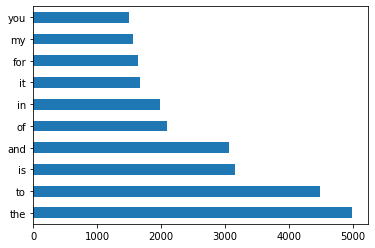

In [33]:
status.sum().sort_values(ascending=False).head(10).plot(kind='barh');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show 10 statuses in the dataset that contain `propname`:

In [34]:
print(df.loc[status[status['propname'] >1].index[0:3],'STATUS'])

170    Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt
245                                                                                                                                                                                                                                                             Nicel little test for *PROPNAME*!! Way to show them *PROPNAME* how to play PRO football!!
446                                                                                                                                                                 *PROPNAME* made it up to me today... after I waited for her for a half hour past our appointment time. Sheesh. But *PROPNAME* was awesome enough

#### Provide a short explanation of what you believe `propname` to be:

> Note: The attached PDF also contains an explanation.
* Answer: Propnames have been used to replace the proper name

-----

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality columns from the original dataframe.

### Create a new dataframe with the vectorized text _and_ the personality category columns

> Note: One way to do this is by using [`pd.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html).

In [221]:
status_personality = pd.concat([df[['cEXT','cNEU','cAGR','cCON','cOPN']],status],axis=1)

### Show the 25 most common words for statuses from high-cAGR users

In [214]:
status_personality[status_personality['cAGR'] == 1].drop(['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'],axis=1).sum().sort_values(ascending=False).head(25)

to          66
the         60
is          43
and         42
in          25
of          23
it          21
for         21
you         18
my          17
on          16
be          16
this        16
that        14
propname    13
will        12
all         11
me          11
out         10
just        10
with         9
one          8
how          8
then         8
going        8
dtype: int64

### Show the 25 most common words for statuses from low-cAGR users

In [39]:
status_personality[status_personality['cAGR'] == 0].drop(['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN'],axis=1).sum().sort_values(ascending=False).head(25)

the          65
is           43
to           39
and          29
in           24
of           24
for          17
my           15
at           15
not          14
it           14
be           12
will         12
propname     11
so           10
up           10
from         10
with         10
that          9
we            9
night         9
can           9
then          9
you           8
champions     8
dtype: int64

-----

### (BONUS) Most common bigrams:

This is a bonus section and not required.

Find the 10 most common bigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

In [45]:
cvec_new = CountVectorizer(ngram_range=(2,2))

status_new = cvec_new.fit_transform(df['STATUS'])

vect_bigrams = pd.DataFrame(status_new.todense(),columns = cvec_new.get_feature_names())

vect_bigrams.sum().sort_values(ascending=False).head(10)

in the      448
of the      323
for the     318
going to    295
to the      290
to be       284
on the      217
at the      172
to get      165
to go       162
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required.

Find the 10 most common trigrams in the dataset.

> Note: The easiest way to do this involves instantiating a new `CountVectorizer`.

In [47]:
cvec_new_3 = CountVectorizer(ngram_range=(3,3))

status_new_3 = cvec_new_3.fit_transform(df['STATUS'])

vect_trigrams = pd.DataFrame(status_new_3.todense(),columns = cvec_new_3.get_feature_names())

vect_trigrams.sum().sort_values(ascending=False).head(10)

is going to                   93
propname and propname         56
going to be                   45
looking forward to            41
to go to                      38
going to the                  35
propname propname propname    34
out of the                    32
in the morning                29
the rest of                   28
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:

- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate.

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

---

> Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?

In [72]:
# check zipcode
for i in status.columns:
    test = re.match('^[0-9]{5}(?:-[0-9]{4})?$',i)
    if test:
        print(test.group())
        
# looks like zip codes haven't been redacted.

10014
13500
15000
20307
24676
58530
67259
67878
70000


In [73]:
# check zipcode
for i in status.columns:
    test = re.match('^(\+\d{1,2}\s)?\(?\d{3}\)?[\s.-]\d{3}[\s.-]\d{4}$',i)
    if test:
        print(test.group())
    
# looks like all the phone numbers have been redacted.

---

> Investigating if any public figures or famous people show up in the dataset, or their names have been redacted as well. 

In [78]:
df[df['STATUS'].str.contains('Obama')]
# looks lile public figures havn't been redacted.

#AUTHID  \
799   c19a4fb5e846fb6575b0a8f3a2081ea0   
2096  8f9d4ed5d16ed1a67d734196d29d1f6b   
3881  9f320ade181aa12bf10361871afa8d90   
6355  1886cffe45f0ee0240eda42e44a01e07   
6555  8d7faa6d7f104a6cb7c4a9e1c6310a15   
7493  1187ed8a8b100eb49b8684ac30d6da29   
7518  1187ed8a8b100eb49b8684ac30d6da29   
8495  a40e2ef8193f5273a04cc7bbaae0789c   
8833  7d41c244db4ee816029991d903cc7ce1   

                                                                                                                                                                                                                                                                                                                               STATUS  \
799                                                                                                                                                                                                                                            prøver å forsvare Obama til min norsk romkamerat på norsk og det er utrolig vanskelig.   
2096                                                                                                                                                                                                                                                                             Can Obama will the US to victory over Brazil Sunday?   
3881  An Obama consultant yesterday on taxing high-value, middle class health care plans: "We're not talking about a new tax on these people. We're saying they currently get an enormous tax break and we're going to slightly scale that back . . ." This will likely be the talking point for any new, middle-class taxes to come.   
6355                                                                                                                                                                                                           @_@ turkeyday for me = a bunch of republicans coming together eating a huge feast and Obama bashing....its disgusting!   
6555                                                                                                                                                                                                                                                       is temporarily upset with Obama for being in a commercial with *PROPNAME*.   
7493                                                                                                                                                                                  President Obama -- fighting wars in two countries -- will arrive in Norway on Thursday to accept the Nobel Peace Prize.... Amusing CNN headline   
7518                                                                                                                                                                                                                                           Obama got the Nobel Peace Prize the same day that we bombed the moon... interesting...   
8495                                                                                                                                                                                                                                                                                     ... Obama won the Nobel Peace Prize?  Weird.   
8833                                                                                                                                                                                                                                                                                                yeah Obama, let's fix this thing!   

      cEXT  cNEU  cAGR  cCON  cOPN               DATE  status_char_length  \
799      0     1     0     1     0  08/19/09 08:50 PM                  86   
2096     1     0     1     1     1  06/27/09 11:24 PM                  52   
3881     0     1     0     1     0  01/12/10 04:41 PM                 319   
6355     1 

---

> Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?

In [194]:
# Vectorize the df again without lowercase everything
cvec_cap = CountVectorizer(lowercase=False)
cvec_cap.fit(df['STATUS'])
status_vec_cap = cvec_cap.transform(df['STATUS'])

In [195]:
status_cap = pd.DataFrame(status_vec_cap.todense(),columns=cvec_cap.get_feature_names())

In [196]:
status_personality_cap =  pd.concat([unique_users.drop('#AUTHID',axis=1),status_cap],axis=1)

In [188]:
status_personality_columns = status_cap.columns

In [189]:
status_personality_cap_columns = []
for i in status_personality_columns:
    if i == i.title() and (not i[0].isdigit()):
        status_personality_cap_columns.append(i)


In [200]:
df_cap = status_personality_cap.loc[:,status_personality_cap_columns]

In [218]:
status_personality_cap = pd.concat([df[['cEXT','cNEU','cAGR','cCON','cOPN']],df_cap],axis=1)

In [251]:
df_not_cap = status_cap.loc[:,[column for column in status_cap.columns if column not in status_personality_cap_columns]]

In [254]:
df_not_cap = pd.concat([df[['cEXT','cNEU','cAGR','cCON','cOPN']],df_not_cap],axis=1)

In [258]:
(status_personality_cap.groupby('cNEU').sum().sum(axis=1)[1]) / (df_not_cap.groupby('cNEU').sum().sum(axis=1)[1])

0.21235069092044656

In [259]:
(status_personality_cap.groupby('cEXT').sum().sum(axis=1)[1]) / (df_not_cap.groupby('cEXT').sum().sum(axis=1)[1])

0.23449377195784094

In [260]:
(status_personality_cap.groupby('cAGR').sum().sum(axis=1)[1]) / (df_not_cap.groupby('cAGR').sum().sum(axis=1)[1])

0.2392568913111833

In [261]:
(status_personality_cap.groupby('cCON').sum().sum(axis=1)[1]) / (df_not_cap.groupby('cCON').sum().sum(axis=1)[1])

0.24367025133846604

In [262]:
(status_personality_cap.groupby('cOPN').sum().sum(axis=1)[1]) / (df_not_cap.groupby('cOPN').sum().sum(axis=1)[1])

0.2304590721399077

### The ratio between uppercase letters and lowercase letters aren't vary too much between different personality category